# FFT as Linear Operator

**Author: M. Ravasi, KAUST**

Welcome to the first exercise of the **An introduction to proximal solvers for engineers** course!

The aim of this tutorial is to:

- Introduce the concept of *linear operator* and the difference with dense matrices in both computation time and memory load;
- Show how PyLops can be used to set-up linear operators and solve inverse problems in Python;

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pympler pynufft pyproximal

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pympler
import pyproximal

from pynufft import NUFFT

from pylops import FirstDerivative, MatrixMult, Restriction, SecondDerivative
from pylops.signalprocessing import FFT
from pylops.optimization.leastsquares import regularized_inversion
from pylops.utils import dottest

from fft import *
from nufft import *

## The Fourier Transform

The Fourier Transform is a powerful tool in signal processing to decompose a signal into a linear combination of complex sinusoids:

$$
X(f) = \int x(t) e^{-j 2 \pi f t} dt
$$

whose inverse is represented by 

$$
x(t) = \int X(f) e^{j 2 \pi f t} df
$$

In practice, this integral is discretized giving rise to the Discrete Fourier Transform (DFT):

$$
X_k = \frac{1}{\sqrt{N}}\sum_{n=0}^{N-1} x_n e^{-j 2 \pi \frac{k}{N} n}
$$

and its inverse:

$$
x_n = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} X_k e^{j 2 \pi \frac{k}{N} n}
$$

Note the presence of the $1/\sqrt{N}$ factor in front of both the forward and inverse DFT. This is to allow symmetry between the two operations and ensure that the inverse is also the adjoint. We will come back to this point later.

Let's now put what we have learned into practice.



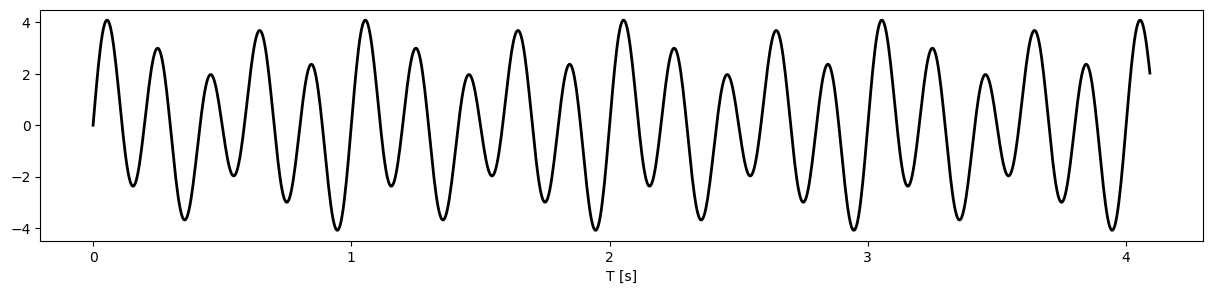

In [2]:
# Time axis
dt = 0.004 # time sampling (seconds)
nt = 1024 # number of time samples
t = np.arange(nt) * dt

# Frequencies and amplitudes
f0 = [2, 4, 5]
a = [1, 0.5, 3]

# Create signal
x = np.sum([a_* np.sin(2*np.pi*f_*t)for f_, a_ in zip (f0, a)], axis=0)

plt.figure(figsize=(15, 3))
plt.plot(t, x, 'k', lw=2)
plt.xlabel('T [s]')
plt.axis('tight');

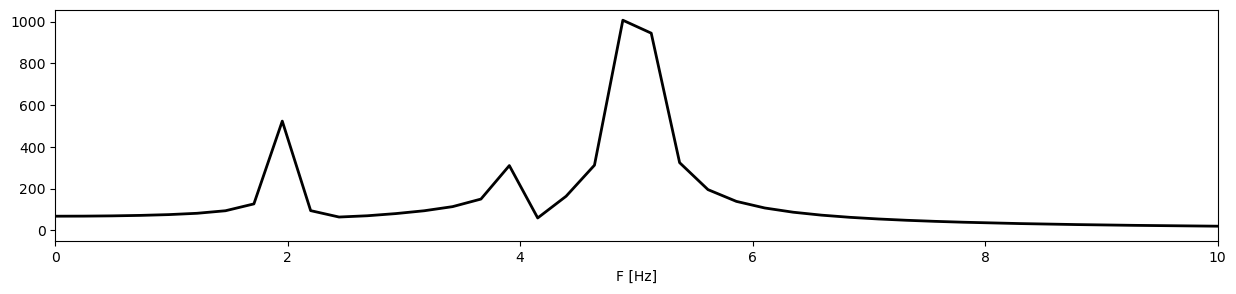

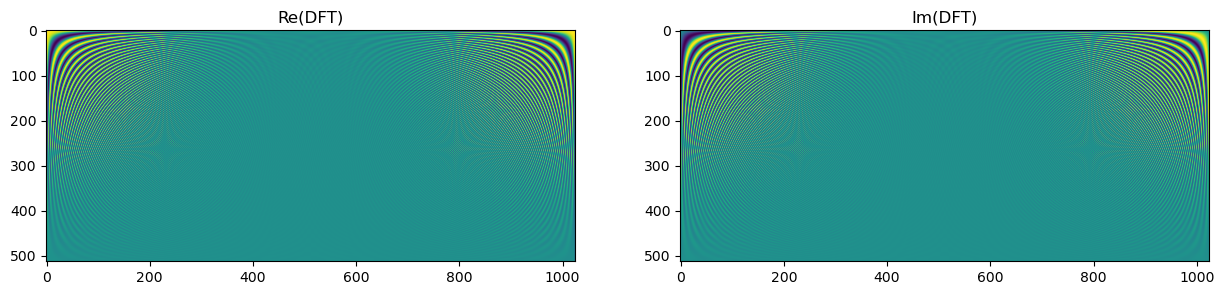

In [3]:
# Compute DFT
X, D = DFT(x)
f = np.fft.rfftfreq(nt, dt)

plt.figure(figsize=(15, 3))
plt.plot(f[:nt//2], np.abs(X[:nt//2]), 'k', lw=2)
plt.xlabel('F [Hz]')
plt.axis('tight')
plt.xlim(0, 10);

fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].imshow(D.real)
axs[0].set_title('Re(DFT)')
axs[0].axis('tight')
axs[1].imshow(D.imag)
axs[1].set_title('Im(DFT)')
axs[1].axis('tight');

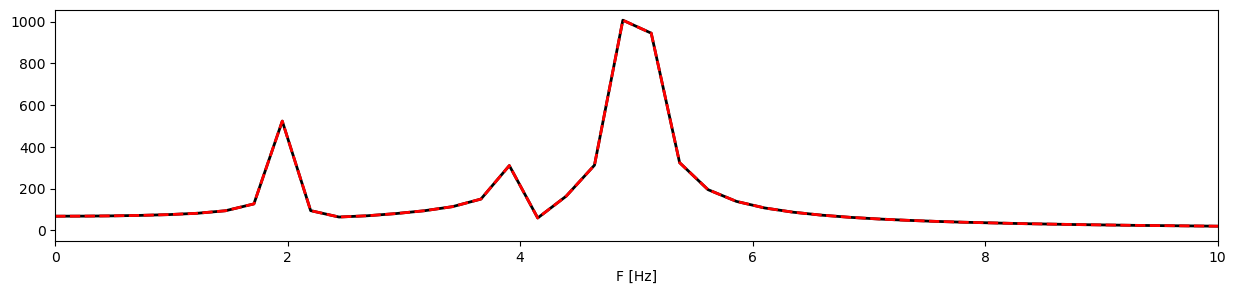

In [4]:
# Compute FFT
Xf = np.fft.rfft(x)

plt.figure(figsize=(15, 3))
plt.plot(f[:nt//2], np.abs(X[:nt//2]), 'k', lw=2, label='DFT')
plt.plot(f[:nt//2], np.abs(Xf[:nt//2]), '--r', lw=2, label='FFT')
plt.xlabel('F [Hz]')
plt.axis('tight')
plt.xlim(0, 10);

### Timings

In [19]:
def FFT_time(n):
    """Timing of of DFT/FFT operator
    """
    x = np.arange(n)
    _, D = DFT(x)
    Dop = FFT(n, engine='scipy', real=True)
    
    print('Timings for DFT, FFT-scipy, FFT-pylops(scipy)')
    %timeit -n 50 -r 2 np.dot(D, x)
    %timeit -n 50 -r 2 sp.fft.rfft(x)
    %timeit -n 50 -r 2 Dop.matvec(x)

In [20]:
nt_time = 2 **12
FFT_time(nt_time)

Timings for DFT, FFT-scipy, FFT-pylops(scipy)
1.86 ms ± 8.62 μs per loop (mean ± std. dev. of 2 runs, 50 loops each)
12.5 μs ± 365 ns per loop (mean ± std. dev. of 2 runs, 50 loops each)
18.3 μs ± 535 ns per loop (mean ± std. dev. of 2 runs, 50 loops each)


### Memory

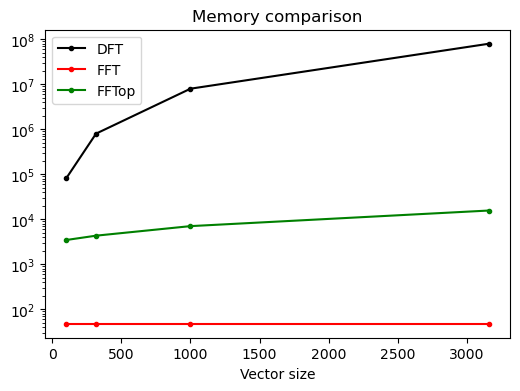

In [24]:
FFT_memory()

## The Fourier transform as Linear Operator

At this point, we know that we can create the Fourier operator in two different ways (and which one is best from both a computational and memory standpoint). 

But can we do the same with the inverse Fourier transform and create a linear operator that passes the dot-test?

In [27]:
# Again DFT
DCTop = MatrixMult(D / np.sqrt(nt//2 + 1), dtype=np.complex128)

dottest(DCTop, verb=True);

Dot test passed, v^H(Opu)=(-23.4382215963517+29.26889883886715j) - u^H(Op^Hv)=(-23.438221596351735+29.268898838867116j)


In [28]:
# FFT
FFTop = FFT(nt, engine='scipy', real=True)
    
dottest(FFTop, complexflag=2, verb=True);

Dot test passed, v^H(Opu)=-24.22652807555548 - u^H(Op^Hv)=-24.226528075555454


In [30]:
# Forward
Xd = DCTop @ x
Xf = FFTop @ x

# Adjoint
xadjd = DCTop.H @ Xd
xadjf = FFTop.H @ Xf

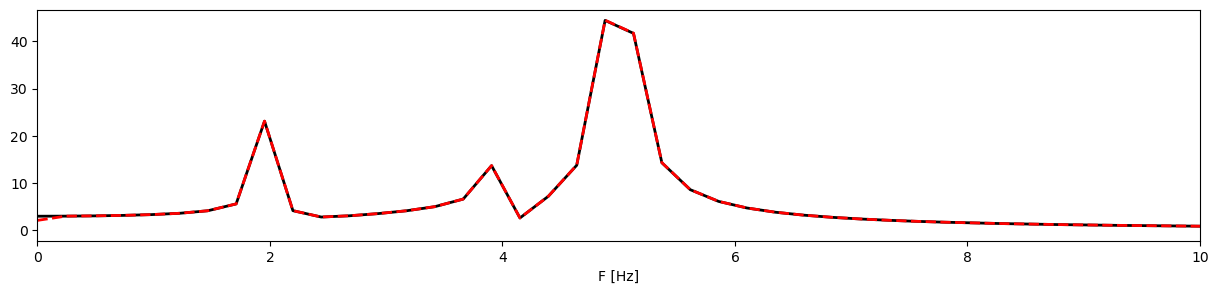

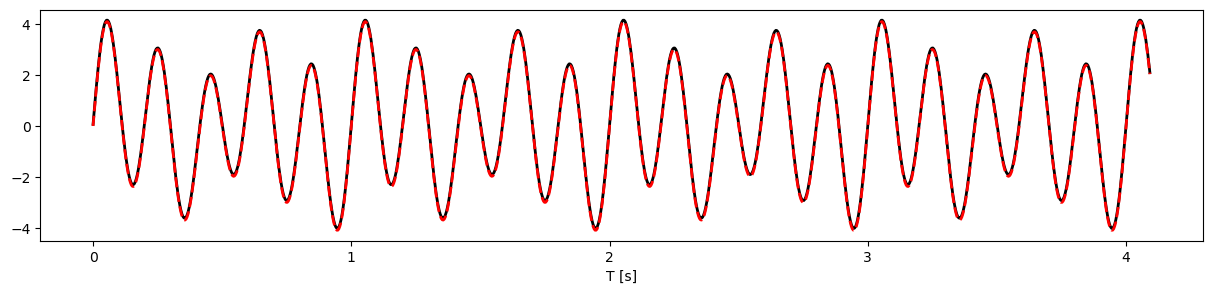

In [31]:
plt.figure(figsize=(15, 3))
plt.plot(f[:nt//2], np.abs(Xd[:nt//2]), 'k', lw=2, label='DFT')
plt.plot(f[:nt//2], np.abs(Xf[:nt//2]), '--r', lw=2, label='FFT')
plt.xlabel('F [Hz]')
plt.axis('tight')
plt.xlim(0, 10);

plt.figure(figsize=(15, 3))
plt.plot(t, xadjd.real, 'k', lw=2, label='DFT')
plt.plot(t, xadjf, '--r', lw=2, label='FFT')
plt.xlabel('T [s]')
plt.axis('tight');

As you can see, we have created two linear operators that do produce the exact same results, although implementing the FFT differently.

## Subsampled Fourier transform

Let's now consider an example where we want to reconstruct a signal from a subsampled Fourier trasform:

$$
\mathbf{y} = \mathbf{RF}\mathbf{x}
$$

where $\mathbf{F}$ and $\mathbf{R}$ are the FFT and restriction operators, respectively. Note that, alternatively, one could use the Non-Uniform FFT (NUFFT) to perform both operations simultaneously. We will look into this towards the end of this lab.

The goal of this exercise is NOT to retrieve a good representation of the input signal from few Fourier coefficients (we will see that this is very difficult in 1D) but to get a feeling once again for how a linear operator can be used within a classical gradient-based iterative solver as well as within a proximal solver. However, to make the example meaningful, I have decided to always retain the first 5 samples of the Fourier representation of the signal, and to discard anything in the very high frequency part of the spectrum.

In [13]:
x = np.zeros(nt)
x[nt//20: nt // 10] = 10
x[nt // 5 : nt // 4] = -5
x[3 * nt // 4 : 6 * nt // 7] = 3

X = FFTop @ x

Fourier domain subsampling factor: 1.7


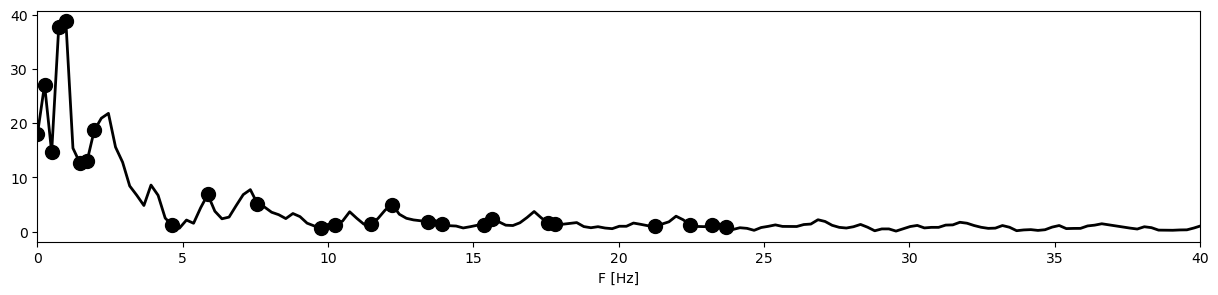

In [14]:
# Create subsampled Fourier domain
np.random.seed(10)

ntsub = 20 # play with this...
ifava = np.hstack([np.arange(5), np.random.permutation(np.arange(5, nt//10))[:ntsub]])
Rop = Restriction(nt//2+1, ifava, dtype=np.complex128)
y = Rop @ FFTop @ x

print('Fourier domain subsampling factor:', ((nt//20)/30))

plt.figure(figsize=(15, 3))
plt.plot(f, np.abs(X), 'k', lw=2)
plt.plot(f[ifava], np.abs(y), '.k', ms=20)
plt.xlabel('F [Hz]')
plt.axis('tight')
plt.xlim(0, 40);

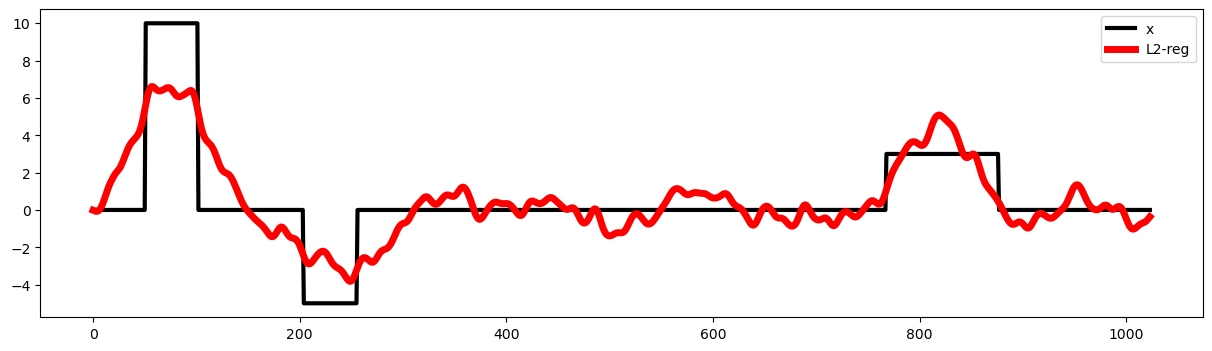

In [15]:
D2op = SecondDerivative(nt, edge=True, dtype=np.complex128)
alpha = 1e2

xinv = regularized_inversion(
    Rop @ FFTop, y, [D2op], epsRs=[np.sqrt(alpha / 2)], **dict(iter_lim=30))[0].real

plt.figure(figsize=(15, 4))
plt.plot(x, "k", lw=3, label="x")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.legend();

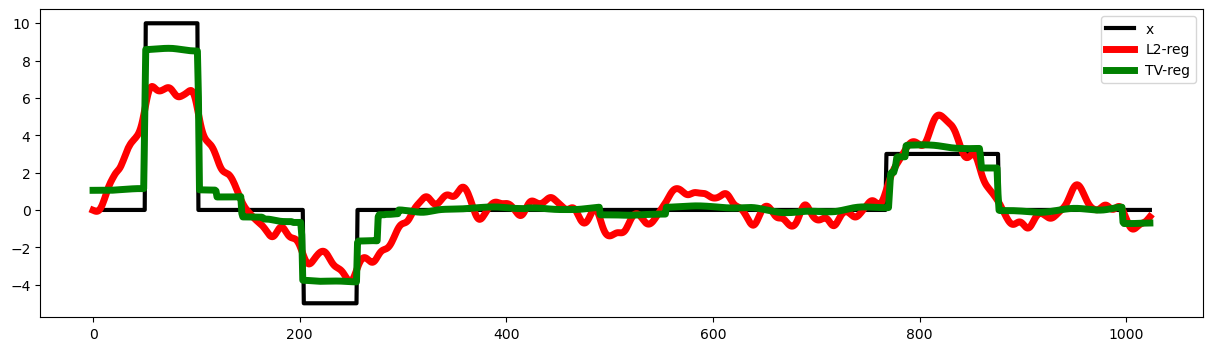

In [16]:
D2op = FirstDerivative(nt, edge=True, kind='backward', dtype=np.complex128)
F = pyproximal.L2(Rop @ FFTop, y, niter=20)
G = pyproximal.L1(3.)

L = (D2op.H @ D2op).eigs(1)[0].real
tau = 1.
mu = tau / L
xtv = pyproximal.optimization.primal.LinearizedADMM(F, G, D2op, np.zeros_like(x).astype(np.complex128),
                                                    tau, mu, niter=500, show=False)[0].real

plt.figure(figsize=(15, 4))
plt.plot(x, "k", lw=3, label="x")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.plot(xtv, "g", lw=5, label="TV-reg")
plt.legend();

Finally, let's explore an alternative approach to compute $\mathbf{RF}\mathbf{x}$ that takes advantage of non-uniform Fast Fourier transform in the [pynufft](https://github.com/pynufft/pynufft) library.

First we test the ``NonUniformFFT`` operator that I created in PyLops for you.

In [17]:
# Full transform
ff = np.arange(-np.pi, np.pi, 2*np.pi/nt).reshape(-1, 1)
NUFFTOp = NonUniformFFT(nt, ff)
dottest(NUFFTOp, complexflag=1, verb=True)

# Partial transform
ntsub = nt // 4
ifava = np.random.permutation(np.arange(nt))[:ntsub]
ff = np.arange(-np.pi, np.pi, 2*np.pi/nt)[ifava].reshape(-1, 1)
NUFFTOp = NonUniformFFT(nt, ff)
dottest(NUFFTOp, complexflag=1, verb=True);

Dot test passed, v^H(Opu)=(42.30821271097315+36.37526642548721j) - u^H(Op^Hv)=(42.30821238236419+36.37526602438129j)
Dot test passed, v^H(Opu)=(-1.8470434063559837-10.13677919322447j) - u^H(Op^Hv)=(-1.8470425411087037-10.136778850224367j)


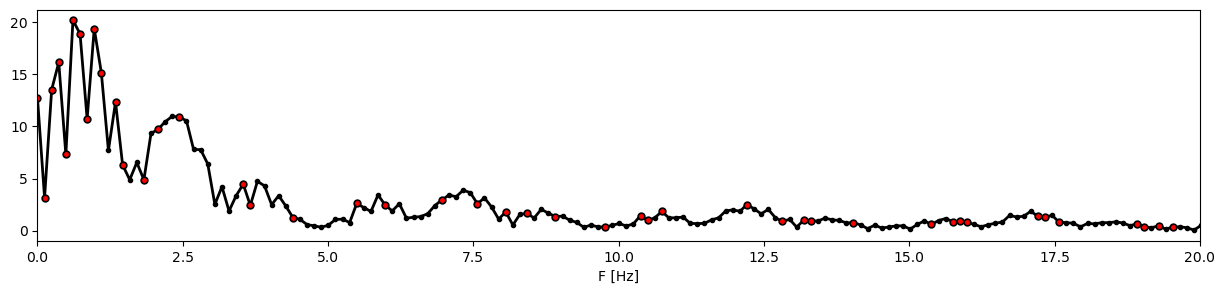

In [18]:
# Create subsampled Fourier domain
np.random.seed(10)

ntsub = 40 # play with this...
ifava = np.hstack([np.arange(10), np.random.permutation(np.arange(10, nt//5))[:ntsub]])

FFTop = FFT(nt, nfft=2*nt, engine='numpy', sampling=dt)
Rop = Restriction(2*nt, ifava, dtype=np.complex128)

f = FFTop.f
ff = np.sort(f[ifava]).reshape(-1, 1) * (2 * np.pi * dt)
NUFFTOp = NonUniformFFT(nt, ff)

X = FFTop @ x
Xnufft = NUFFTOp @ x

plt.figure(figsize=(15, 3))
plt.plot(f[:nt], np.abs(X)[:nt], '.-k', lw=2)
plt.plot(f[ifava], np.abs(Rop @ X), '.k', ms=10)
plt.plot(ff / (2 * np.pi * dt), np.abs(Xnufft), '.r', ms=5)
plt.xlabel('F [Hz]')
plt.axis('tight')
plt.xlim(0, 20);

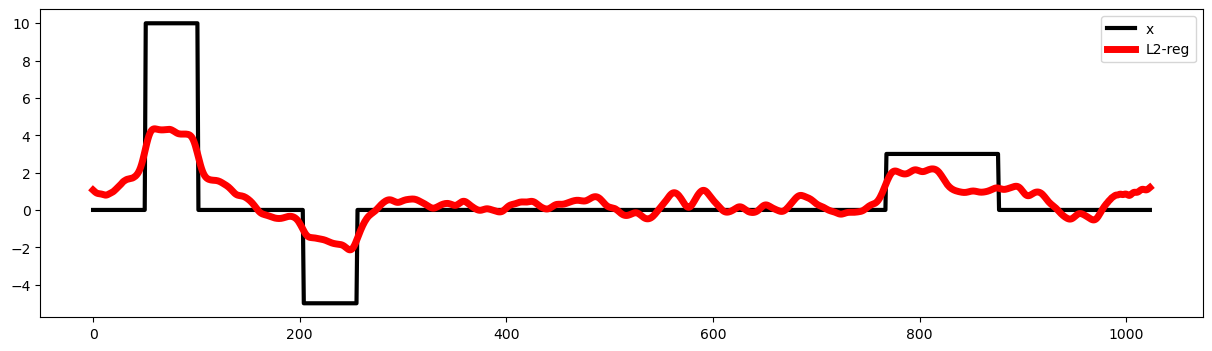

In [19]:
# Inversion
D2op = SecondDerivative(nt, edge=True, dtype=np.complex128)
alpha = 1e2

xinv = regularized_inversion(
    NUFFTOp, Xnufft, [D2op], epsRs=[np.sqrt(alpha / 2)], **dict(iter_lim=30))[0].real

plt.figure(figsize=(15, 4))
plt.plot(x, "k", lw=3, label="x")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.legend();

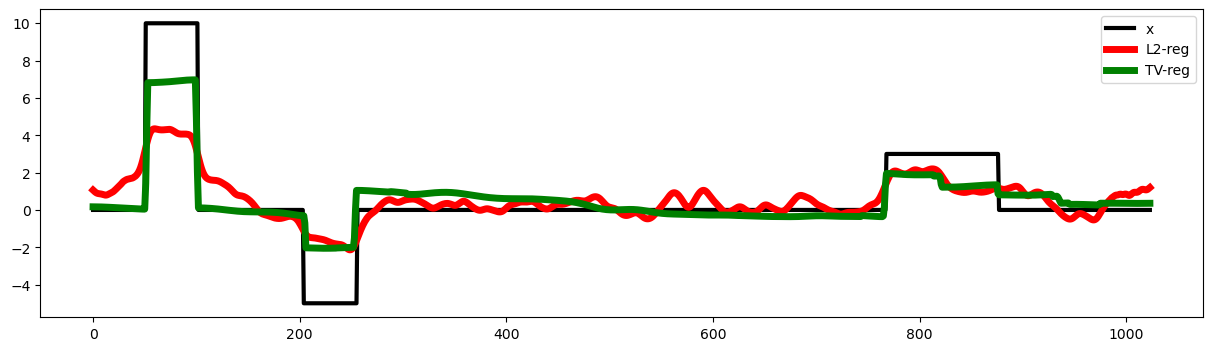

In [20]:
D2op = FirstDerivative(nt, edge=True, kind='backward', dtype=np.complex128)
F = pyproximal.L2(NUFFTOp, Xnufft, niter=20)
G = pyproximal.L1(3.)

L = (D2op.H @ D2op).eigs(1)[0].real
tau = 1.
mu = tau / L
xtv = pyproximal.optimization.primal.LinearizedADMM(F, G, D2op, np.zeros(nt).astype(np.complex128),
                                                    tau, mu, niter=500, show=False)[0].real

plt.figure(figsize=(15, 4))
plt.plot(x, "k", lw=3, label="x")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.plot(xtv, "g", lw=5, label="TV-reg")
plt.legend();

Finally, let's consider a much larger signal and compare the two different approaches used so far to obtain irregularly sampled values in the Fourier domain

In [21]:
# Create subsampled Fourier domain
np.random.seed(10)

nt = 2 ** 18
ntsub = 20
ifava = np.random.permutation(np.arange(2*nt))[:ntsub]

FFTop = FFT(nt, nfft=2*nt, engine='numpy', sampling=dt)
Rop = Restriction(2*nt, ifava, dtype=np.complex128)

f = FFTop.f
ff = np.sort(f[ifava]).reshape(-1, 1) * (2 * np.pi * dt)
NUFFTOp = NonUniformFFT(nt, ff)

x = np.ones(nt)

In [22]:
%timeit -n 5 -r 5 Rop @ FFTop @ x
%timeit -n 5 -r 5 NUFFTOp @ x

9.22 ms ± 2.12 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
8.43 ms ± 334 μs per loop (mean ± std. dev. of 5 runs, 5 loops each)


## Recap

In this first tutorial we have learned to:

- perform the Fourier transform with a linear operator implementing the FFT (instead of a dense matrix implementing the DFT);
- use PyLops FFT linear operators to solve a simple optimization problem.
- build a custom PyLops operator with PyNUFFT and solve the same simple optimization problem.